In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from globalfunctions import *
%matplotlib inline

tickers = ['MTUM','SSO']


In [2]:
# format epoch time to datetime
def convertTime(dtEpoch):
    formattedDate = datetime.datetime.fromtimestamp(dtEpoch).strftime('%Y-%m-%d')
    return formattedDate

# Get Historical Data
def GetModalData(tickers = []):
    dfs = []
    key =  getData("SELECT [keyValue] FROM [fattailinvestorweb].[dbo].[tblAPIKeys] where pkAPIID = 1")
    
    for t in tickers:
        priceHistory = get_price_history(key['keyValue'][0],symbol=t, period=1, periodType='year', frequencyType='weekly')
        df = pd.DataFrame(priceHistory['candles'],columns=['open','high','low','close','volume','datetime','ticker'])
        df['ticker'] = t
        df['MA20'] = df['close'].rolling(20).mean()
        # Convert epoch time to standard time, and add 5 days to be 'close of week'
        df['datetime'] = (df['datetime']/1000)+(86400*5)
        df['datetime'] = df['datetime'].apply(convertTime)
        dfs.append(df)
    return dfs
    

In [3]:
dfs = GetModalData(tickers)



In [4]:
def SMA(df,lbl,N):
    dfCopy = df
    colName = 'ROC'+str(N)
    dfCopy[colName] = np.NaN
    colIndex = dfCopy.columns.get_loc(colName)
    adjCloseIndex = dfCopy.columns.get_loc(lbl)
    for i, j in dfCopy.iterrows():
        if i >= N-1:
            dfCopy.iloc[i,colIndex] = dfCopy.iloc[i,adjCloseIndex]/dfCopy.iloc[i-N,adjCloseIndex]-1
    
    return dfCopy
    
    

In [5]:
def PrepData(dfs,N):
    # create local copy of DataFrams list
    cDfs = dfs
    # Set name of new column to be added to each df in dfs
    rocCol = 'ROC'+str(N)
    pMACol = 'PrctMA' + str(N)
    # for each df in cDfs 1) add 'rocCol' and 'PrctMA', and calculate ROC for each row
    for cDf in cDfs:
        # Add new column to df and set equal to NaN
        cDf[rocCol] = np.NaN
        cDf[pMACol] = np.NaN
        # Get column index of newly created column
        rocIndex = cDf.columns.get_loc(rocCol)
        prctIndex = cDf.columns.get_loc(pMACol)
        MAIndex = cDf.columns.get_loc('MA20')
        # Get column index of close data for calcs
        adjCloseIndex = cDf.columns.get_loc('close')
        # for each row, calculate ROC over price(i)/price(i-n)
        for i,j in cDf.iterrows():
            if i>= N-1:
                # set ith row for newly created column equal to ROC calculation
                cDf.iloc[i,rocIndex] = cDf.iloc[i,adjCloseIndex]/cDf.iloc[i-N,adjCloseIndex]-1
                # set ith row for newly created column equal to close/SMA
                cDf.iloc[i,prctIndex] = cDf.iloc[i,adjCloseIndex]/cDf.iloc[i,MAIndex]-1
    return cDfs

In [6]:
dfs = PrepData(dfs,20)

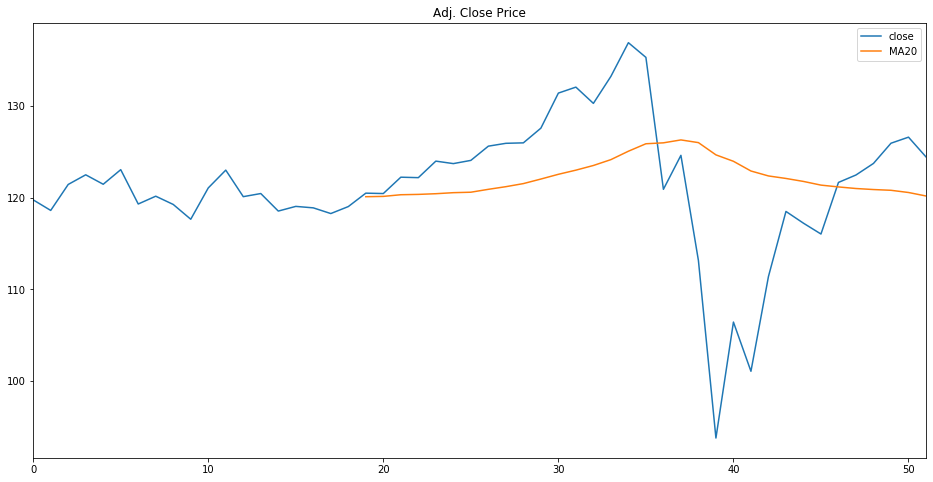

In [7]:
dfs[0][['close','MA20']].plot(label='MTUM', figsize=(16,8), title='Adj. Close Price');

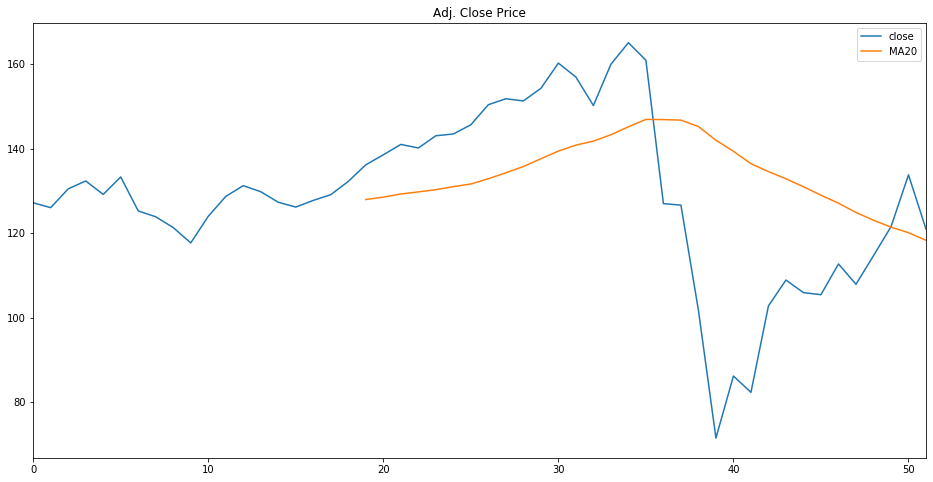

In [8]:
dfs[1][['close','MA20']].plot(label='SSO', figsize=(16,8), title='Adj. Close Price');

In [10]:
def SPMomentum(df):
    positions = []
    for i,j in df.iterrows():
        pCount= len(positions)
        if pCount == 0:
            if j['ROC20'] >=0 or j['PrctMA20']>=0:
                pos = Position(j['close'],j['datetime'],0,'01/01/1900',0,'Long',j['ticker'])
                positions.append(pos)
        else:
            latestPosition = positions[pCount-1]
            if j['ROC20'] >=0 or j['PrctMA20']>=0:
                if latestPosition.exitPrice >0:
                    # Enter new position if latest position was closed since entry criteria is met
                    pos = Position(j['close'],j['datetime'],0,'01/01/1900',0,'Long',j['ticker'])
                    positions.append(pos)
            else:
                if latestPosition.exitPrice == 0:
                    latestPosition.exitPrice = j['close']
                    latestPosition.exitDate = j['datetime']
                    latestPosition.profitLoss = j['close']/latestPosition.entryPrice
                    positions.pop()
                    positions.append(latestPosition)
    return positions

In [12]:
pos = []
for df in dfs:
    p = SPMomentum(df)
    pos.append(p)


In [42]:
for p in pos:
    ticker = p[0].ticker
    create(p,ticker,2)


                   MTUM   ROC+SMA
0     Total Return (TR)  0.939077
1          Buy and Hold  0.009711
2      Geometric Return -0.060923
3                  Mean -0.060923
4                 StDev  0.000000
5                   Min -0.060923
6                Median -0.060923
7                   Max -0.060923
8                     N  1.000000
9   Bootstrap Median TR  0.939077
10   Bootstrap Stdev TR  0.000000
                    SSO       ROC+SMA
0     Total Return (TR)  9.324324e-01
1          Buy and Hold -1.077409e-01
2      Geometric Return -6.756757e-02
3                  Mean -6.756757e-02
4                 StDev  0.000000e+00
5                   Min -6.756757e-02
6                Median -6.756757e-02
7                   Max -6.756757e-02
8                     N  1.000000e+00
9   Bootstrap Median TR  9.324324e-01
10   Bootstrap Stdev TR  4.440892e-16


In [1]:
ModelAssessment(pos[0],'SP500','ROC+SMA')

NameError: name 'ModelAssessment' is not defined

1928-05-07 20.360001 1929-10-28 24.15 1.186149254118406
1930-02-10 23.35 1930-06-16 20.25 0.867237687366167
1931-02-09 17.18 1931-03-30 16.450001 0.9575087892898719
1931-05-04 15.44 1931-05-11 14.44 0.9352331606217616
1932-07-25 6.03 1932-12-19 6.57 1.0895522388059702
1933-04-17 7.44 1933-10-16 8.86 1.1908602150537633
1933-12-04 10.1 1933-12-11 10.07 0.9970297029702971
1934-01-08 10.07 1934-05-07 9.55 0.948361469712016
1934-11-05 9.3 1935-02-11 9.06 0.9741935483870967
1935-02-18 9.03 1935-02-25 8.79 0.9734219269102989
1935-04-15 9.14 1937-04-05 17.030001000000002 1.8632386214442014
1937-07-19 16.940001000000002 1937-08-23 15.88 0.9374261548154571
1938-02-21 11.57 1938-02-28 11.13 0.961970613656007
1938-06-20 11.15 1938-12-05 12.32 1.104932735426009
1938-12-12 12.9 1939-01-09 12.33 0.9558139534883721
1939-01-16 12.75 1939-01-23 11.86 0.9301960784313725
1939-01-30 12.3 1939-02-20 12.54 1.019512195121951
1939-02-27 12.86 1939-03-13 12.21 0.9494556765163298
1939-06-05 11.8 1939-06-12 11.28